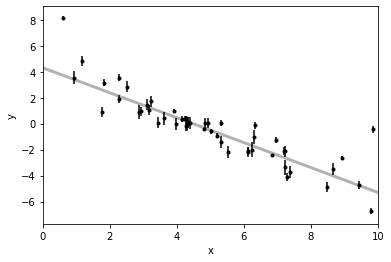

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) # generate random x coords
yerr = 0.1 + 0.5 * np.random.rand(N) # error in y

y = m_true * x + b_true # true y
y += np.abs(f_true * y) * np.random.randn(N) # perturbed y
y += yerr * np.random.randn(N)  # error with random noise

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [6]:
(yerr ** 2)[:,None].shape

(50, 1)

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


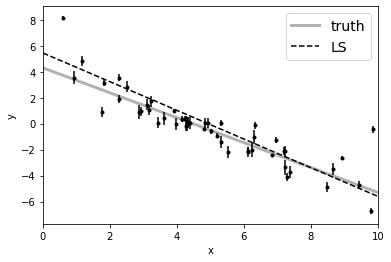

In [9]:
A = np.vander(x, 2) # A matrix [[1 x_1]...[1 x_n]]
C = np.diag(yerr * yerr) # C matrix
ATA = np.dot(A.T, A / (yerr ** 2)[:, None]) # A transpose
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [10]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


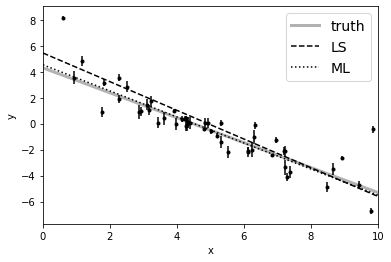

In [11]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [12]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [15]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

You must install the tqdm library to use progress indicators with emcee


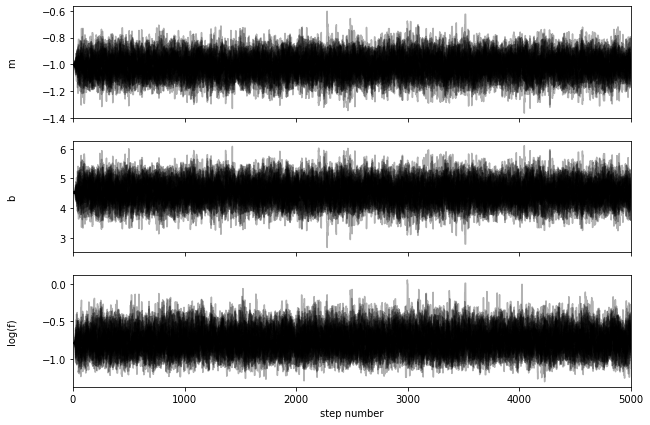

In [16]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [20]:
tau = sampler.get_autocorr_time()
print(tau) # 40 steps for burn in

[36.08728031 36.14802288 39.95956397]


In [18]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True) # discard initial 100 steps, thin half autocorrelation time, and flatten chain
print(flat_samples.shape)

(10432, 3)


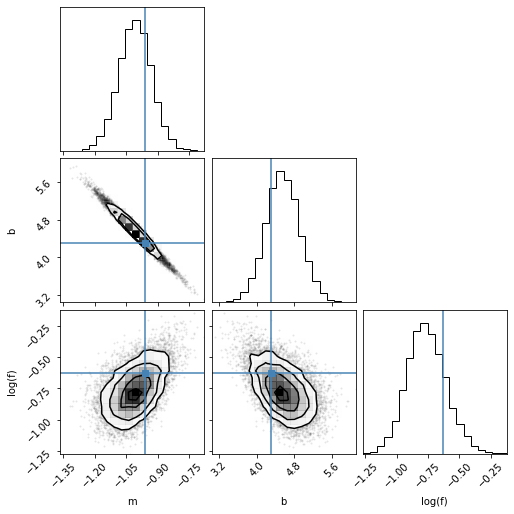

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
); #That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind] # choose sample in chain
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
# choose the true parameters
# equation of circle
# (x-a)**2 + (y-b)**2 = r^2
a = 5
b = 5
r = 2


N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
a**2+b**2-0.2

In [7]:
A = np.vander(x, 2)

array([[0.59677897, 1.        ],
       [0.9210494 , 1.        ],
       [1.15618395, 1.        ],
       [1.75451756, 1.        ],
       [1.8249173 , 1.        ],
       [2.26851454, 1.        ],
       [2.28263231, 1.        ],
       [2.50455365, 1.        ],
       [2.86139335, 1.        ],
       [2.93714046, 1.        ],
       [3.12261223, 1.        ],
       [3.17285482, 1.        ],
       [3.22958914, 1.        ],
       [3.43178016, 1.        ],
       [3.61788656, 1.        ],
       [3.92117518, 1.        ],
       [3.98044255, 1.        ],
       [4.14826212, 1.        ],
       [4.2310646 , 1.        ],
       [4.2583029 , 1.        ],
       [4.26351307, 1.        ],
       [4.30862763, 1.        ],
       [4.33701173, 1.        ],
       [4.38572245, 1.        ],
       [4.80931901, 1.        ],
       [4.83034264, 1.        ],
       [4.93685098, 1.        ],
       [5.01836676, 1.        ],
       [5.19485119, 1.        ],
       [5.31551374, 1.        ],
       [5.